In [52]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# parallelisation functionality
from multiprocess import Pool
import psutil
from tqdm import tqdm

# Analysis of the effect of before/after an election

In [2]:
src = "../data"
fname = "KnowWho_profiles_merged_twitter.csv"
knowwho_profiles = pd.read_csv(
    Path(src, fname), 
    dtype={"author_id":str},
    parse_dates=["created_at", "ELECTIONDATE"]
)

In [3]:
knowwho_profiles["STATUS"].value_counts()

STATUS
Running               1426
Withdrew From Race     168
Name: count, dtype: int64

In [4]:
knowwho_profiles = knowwho_profiles[knowwho_profiles["STATUS"] == "Running"].reset_index(drop=True)
knowwho_profiles = knowwho_profiles.drop(columns=["STATUS", "ELECTIONCODE"])
knowwho_profiles = knowwho_profiles.dropna(subset=["handle"])
# note: it is necessary to have a double-index, since there is one candidate
# (farrforus) who ran in two elections
knowwho_profiles = knowwho_profiles.set_index(["handle", "ELECTIONDATE"])

In [5]:
len(knowwho_profiles)

1204

In [6]:
knowwho_profiles["PARTY"].value_counts()

PARTY
R    652
D    552
Name: count, dtype: int64

In [7]:
knowwho_profiles["INCUMBENT"].value_counts()

INCUMBENT
Y    361
Name: count, dtype: int64

In [8]:
len(knowwho_profiles)

1204

## Calculate the number of tweets before and after election

In [9]:
fname = "midterm_tweets_2022-01-01_to_2023-05-01.csv.gzip"
tweets = pd.read_csv(
    Path(src, fname),
    dtype={"id":str, "author_id":str},
    parse_dates=["created_at"],
    compression="gzip"
)

In [10]:
tweets = tweets[tweets["tweet_length"] > 10].reset_index(drop=True)

In [11]:
knowwho_profiles["N_tweets_before"] = np.nan
knowwho_profiles["N_tweets_after"] = np.nan

In [12]:
i = 0
for handle, electiondate in knowwho_profiles.index:
    if i%100 == 0:
        print(f"{i}/{len(knowwho_profiles)}")
    # select only tweets of the candidate from the four weeks before and after 
    # the election date
    candidate_tweets = tweets[tweets["handle"] == handle]
    candidate_tweets_before = candidate_tweets[
        (candidate_tweets["created_at"].dt.date <= electiondate.date()) & \
        (candidate_tweets["created_at"].dt.date >= electiondate.date() - pd.Timedelta(days=28))
    ]
    candidate_tweets_after = candidate_tweets[
        (candidate_tweets["created_at"].dt.date > electiondate.date()) & \
        (candidate_tweets["created_at"].dt.date <= electiondate.date() + pd.Timedelta(days=28))
    ]
    knowwho_profiles.loc[(handle, electiondate), "N_tweets_before"] = len(candidate_tweets_before)
    knowwho_profiles.loc[(handle, electiondate), "N_tweets_after"] = len(candidate_tweets_after)
    i += 1

0/1204
100/1204
200/1204
300/1204
400/1204
500/1204
600/1204
700/1204
800/1204
900/1204
1000/1204
1100/1204
1200/1204


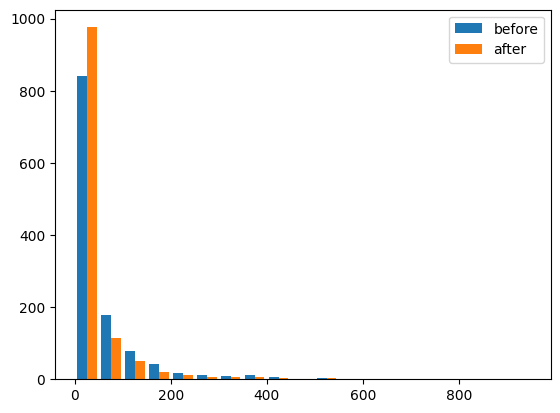

In [13]:
fig, ax = plt.subplots()
ax.hist([knowwho_profiles["N_tweets_before"], knowwho_profiles["N_tweets_after"]],
        bins=range(0, 1000, 50), rwidth=0.8, label=["before", "after"])
ax.legend();

In [25]:
len(knowwho_profiles[(knowwho_profiles["N_tweets_before"] > 0) | (knowwho_profiles["N_tweets_after"] > 0)])

1002

In [27]:
knowwho_profiles[(knowwho_profiles["N_tweets_before"] > 0) | (knowwho_profiles["N_tweets_after"] > 0)]["PARTY"].value_counts()

PARTY
R    533
D    469
Name: count, dtype: int64

In [19]:
knowwho_profiles["N_tweets_before"].mean()

55.470099667774086

In [20]:
knowwho_profiles["N_tweets_before"].std()

116.00293774617238

In [21]:
knowwho_profiles["N_tweets_after"].mean()

38.372093023255815

In [22]:
knowwho_profiles["N_tweets_after"].std()

103.13524561492638

In [28]:
knowwho_profiles["N_tweets_before"].sum()

66786.0

In [29]:
knowwho_profiles["N_tweets_after"].sum()

46200.0

## Power analysis belief-speaking

### LME simulations single core

In [40]:
# define Simulation Parameters
n_sim = 5  # Number of simulations
alpha = 0.05  # Significance level
subset = knowwho_profiles[\
    (knowwho_profiles["N_tweets_before"] > 0) | \
    (knowwho_profiles["N_tweets_after"] > 0)
]
n_democrats = len(subset[subset["PARTY"] == "D"])
mean_tweets_before = subset["N_tweets_before"].mean()
mean_tweets_after = subset["N_tweets_after"].mean()

# sample sizes
n_groups = len(subset)
candidate_sample = subset.sample(n_groups)
n_obs_per_group = (candidate_sample["N_tweets_before"] + \
                   candidate_sample["N_tweets_after"]).values.astype(int)
total_n = n_obs_per_group.sum()

# variance components
var_intercept = 0.002531
var_slope_E = 0.001491
cov_intercept_slope_E = -0.000195
var_residual = 0.011907478206024906

# fixed effect sizes (these are the effects you want to detect)
beta_E = 0.04 # effect of before/after election
beta_P = 0.04 # effect of party
beta_EP = 0.04  # interaction effect between before/after and party

# Store p-values for the effect of interest
p_values_E = []
p_values_P = []
p_values_EP = []

for i in range(n_sim):
    if i%10 == 0:
        print(f"{i}/{n_sim}")

    # generate simulated data
    group = np.repeat(np.arange(n_groups), n_obs_per_group)
    
    # binary predictor P sampled from distribution of party affiliations
    P_group = np.random.binomial(1, n_democrats/ n_groups, n_groups)  
    P_observations = np.repeat(P_group, n_obs_per_group)

    # binary predictor E sampled from distribution of before / after election tweets
    E = np.random.binomial(1, mean_tweets_before / (mean_tweets_before + mean_tweets_after), total_n)  

    # random effects
    mean = [0, 0]
    cov = [[var_intercept, cov_intercept_slope_E],
           [cov_intercept_slope_E, var_slope_E]]
    random_effects = np.random.multivariate_normal(mean, cov, n_groups)
    random_intercepts = random_effects[:, 0][group]
    random_slopes_E = random_effects[:, 1][group]
    errors = np.random.normal(0, np.sqrt(var_residual), total_n)

    # calculate dependent variable
    D = (0 + \
         (beta_E + random_slopes_E) * E + \
         beta_P * P_observations + \
         beta_EP * E * P_observations + \
         random_intercepts + errors)
    data = pd.DataFrame({'D':D, 'C':group, 'P':P_observations, 'E':E})

    # fit the linear mixed effects model
    model = smf.mixedlm(
        "D ~ E * P", 
        data, 
        groups=data["C"],
        re_formula="1 + E"
    )
    result = model.fit()

    # assess significance of the effects, handle cases where the term is not estimable
    try:
        p_value_E = result.pvalues['E']
        p_values_E.append(p_value_E)
    except KeyError:
        p_values_E.append(np.nan)
    try:
        p_value_P = result.pvalues['P']
        p_values_P.append(p_value_P)
    except KeyError:
        p_values_P.append(np.nan)
    try:
        p_value_EP = result.pvalues['E:P']
        p_values_EP.append(p_value_EP)
    except KeyError:
        p_values_EP.append(np.nan)

0/5


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jana/python_environments/default/lib/python3.12/site-p

In [42]:
# calculate power
power_E = np.nanmean(np.array(p_values_E) < alpha)
power_P = np.nanmean(np.array(p_values_P) < alpha)
power_EP = np.nanmean(np.array(p_values_EP) < alpha)

print(f"Estimated power for the effect on E: {power_E:.4f}")
print(f"Estimated power for the effect on P: {power_P:.4f}")
print(f"Estimated power for the E x P interaction: {power_EP:.4f}")

Estimated power for the effect on E: 1.0000
Estimated power for the effect on P: 1.0000
Estimated power for the E x P interaction: 1.0000


### LME simulations parallel

In [76]:
# define simulation parameters
n_sim = 200  # Number of simulations
alpha = 0.05  # Significance level

# sample sizes
subset = knowwho_profiles[\
    (knowwho_profiles["N_tweets_before"] > 0) | \
    (knowwho_profiles["N_tweets_after"] > 0)
]
n_groups = len(subset)
n_democrats = len(subset[subset["PARTY"] == "D"])
mean_tweets_before = subset["N_tweets_before"].mean()
mean_tweets_after = subset["N_tweets_after"].mean()

# variance components - from script estimate_variance_factors_pilot_data.ipynb
var_intercept = 0.002531
var_slope_E = 0.001491
cov_intercept_slope_E = -0.000195
var_residual = 0.011907478206024906

In [77]:
def simulate_lme(params):
    random_state, beta_E, beta_P, beta_EP = params
    
    n_obs_per_group_before = subset["N_tweets_before"]\
        .sample(n_groups, random_state=random_state)\
        .values.astype(int)
    mean_tweets_before = n_obs_per_group_before.mean()
    
    n_obs_per_group_after = subset["N_tweets_after"]\
        .sample(n_groups, random_state=random_state)\
        .values.astype(int)
    mean_tweets_before = n_obs_per_group_after.mean()
    
    total_n = n_obs_per_group_before.sum() + n_obs_per_group_after.sum()

    group = np.repeat(np.arange(n_groups), n_obs_per_group_before + n_obs_per_group_after)
    P_group = np.random.binomial(1, n_democrats/ n_groups, n_groups)  # binary predictor P
    P_observations = np.repeat(P_group, n_obs_per_group)
    E = np.random.binomial(1, mean_tweets_before / (mean_tweets_before + mean_tweets_after), total_n)  
    
    # random effects
    mean = [0, 0]
    cov = [[var_intercept, cov_intercept_slope_E],
           [cov_intercept_slope_E, var_slope_E]]
    random_effects = np.random.multivariate_normal(mean, cov, n_groups)
    random_intercepts = random_effects[:, 0][group]
    random_slopes_E = random_effects[:, 1][group]
    errors = np.random.normal(0, np.sqrt(var_residual), total_n)

    # calculate dependent variable
    D = (0 + \
         (beta_E + random_slopes_E) * E + \
         beta_P * P_observations + \
         beta_EP * E * P_observations + \
         random_intercepts + errors)
    data = pd.DataFrame({'D':D, 'C':group, 'P':P_observations, 'E':E})

    # fit the linear mixed effects model
    model = smf.mixedlm(
        "D ~ E * P", 
        data, 
        groups=data["C"],
        re_formula="1 + E"
    )
    result = model.fit()

    # assess significance of the effects, handle cases where the term is not estimable
    try:
        p_value_interaction = result.pvalues['E:P']
    except KeyError:
        p_value_interaction = np.nan
    try:
        p_value_P = result.pvalues['P']
    except KeyError:
        p_value_P = np.nan
    try:
        p_value_E = result.pvalues['E']
    except KeyError:
        p_value_E = np.nan

    return (random_state, beta_E, beta_P, beta_EP, p_value_E, p_value_P, p_value_interaction)

In [78]:
beta_Es = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008]
beta_Ps = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008]
beta_EPs = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008]
random_states = range(n_sim)

params = [(i, beta_Es[j], beta_Ps[j], beta_EPs[j])\
              for j in range(len(beta_Es))\
              for i in random_states] 
N_configs = len(params)

In [ ]:
results = pd.DataFrame()
pool = Pool(10)

for tmp1, tmp2, tmp3, tmp4, tmp5, tmp6, tmp7 in tqdm(pool.imap_unordered(
    func=simulate_lme, 
    iterable=params), 
    total=N_configs):

    results = pd.concat([results, pd.DataFrame({
        "random_state":[tmp1],
        "beta_E":[tmp2],
        "beta_P":[tmp3],
        "beta_EP":[tmp4],
        "p_value_E":[tmp5],
        "p_value_P":[tmp6],
        "p_value_EP":[tmp7]
    })])

pool.close()

results["alpha"] = alpha
results["var_intercept"] = var_intercept
results["var_residual"] = var_residual
fname = "elections_belief-speaking_power_analysis.csv"
results.to_csv(Path("../results", fname), index=False)

### Calculate power

In [80]:
# calculate power bootstrapped
results = pd.read_csv("../results/elections_belief-speaking_power_analysis.csv")
power_bootstrap = pd.DataFrame()

n_bootstrap = 100
for beta_E, beta_P, beta_EP in zip(beta_Es, beta_Ps, beta_EPs):
    for n in range(n_bootstrap):
        res = results[
            (results["beta_E"] == beta_E) & \
            (results["beta_P"] == beta_P) & \
            (results["beta_EP"] == beta_EP)
        ].sample(frac=1, replace=True)
    
        power_E = np.nanmean(res["p_value_E"].values < alpha)
        power_P = np.nanmean(res["p_value_P"].values < alpha)
        power_EP = np.nanmean(res["p_value_EP"].values < alpha)
        
        power_bootstrap = pd.concat([power_bootstrap, pd.DataFrame({
            "variable":["$E$"],
            "effect":[beta_E],
            "power":[power_E],
        })])
        power_bootstrap = pd.concat([power_bootstrap, pd.DataFrame({
            "variable":["$P$"],
            "effect":[beta_P],
            "power":[power_P],
        })])
        power_bootstrap = pd.concat([power_bootstrap, pd.DataFrame({
            "variable":["$E \\times P$"],
            "effect":[beta_EP],
            "power":[power_EP]
        })])

### Visualisation of power analysis

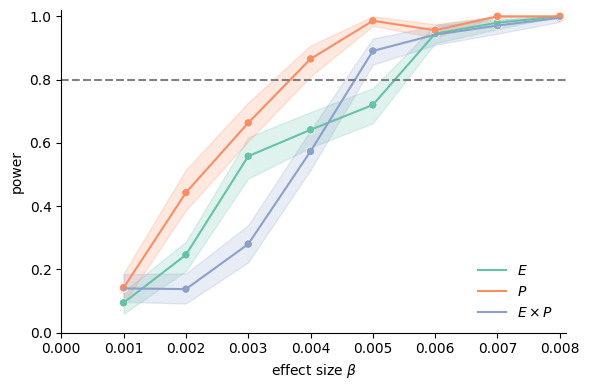

In [84]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(
    data=power_bootstrap,
    ax=ax,
    x="effect", 
    y="power",
    hue="variable",
    errorbar="pi",
    palette="Set2",
)

sns.scatterplot(
    data=power_bootstrap.groupby(["variable", "effect"]).mean().reset_index(),
    ax=ax,
    x="effect",
    y="power",
    hue="variable",
    hue_order=["$E$", "$P$", "$E \\times P$"],
    sizes=[50, 50, 50],
    palette="Set2",
    legend=False
)

ax.set_xlabel("effect size $\\beta$")
ax.spines[['right', 'top']].set_visible(False)
ax.legend(frameon=False)
ax.plot([0, 0.0081], [0.8, 0.8], '--', color="grey")
ax.set_xlim(0, 0.0081)
ax.set_ylim(0, 1.02)
plt.tight_layout()

fname = "power_analysis_elections_belief-speaking"
dst = "../plots"
plt.savefig(Path(dst, fname + ".pdf"))
plt.savefig(Path(dst, fname + ".svg"))

## Power analysis fact-speaking

### LME simulations parallel

In [85]:
# define simulation parameters
n_sim = 100  # Number of simulations
alpha = 0.05  # Significance level

# sample sizes
subset = knowwho_profiles[\
    (knowwho_profiles["N_tweets_before"] > 0) | \
    (knowwho_profiles["N_tweets_after"] > 0)
]
n_groups = len(subset)
n_democrats = len(subset[subset["PARTY"] == "D"])
mean_tweets_before = subset["N_tweets_before"].mean()
mean_tweets_after = subset["N_tweets_after"].mean()

# variance components - from script estimate_variance_factors_pilot_data.ipynb
var_intercept = 0.001828
var_slope_E = 0.001131
cov_intercept_slope_E = -0.000106
var_residual = 0.009419212941440758

In [86]:
beta_Es = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008]
beta_Ps = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008]
beta_EPs = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008]
random_states = range(n_sim)

params = [(i, beta_Es[j], beta_Ps[j], beta_EPs[j])\
              for j in range(len(beta_Es))\
              for i in random_states] 
N_configs = len(params)

In [ ]:
results = pd.DataFrame()
pool = Pool(10)

for tmp1, tmp2, tmp3, tmp4, tmp5, tmp6, tmp7 in tqdm(pool.imap_unordered(
    func=simulate_lme, 
    iterable=params), 
    total=N_configs):

    results = pd.concat([results, pd.DataFrame({
        "random_state":[tmp1],
        "beta_E":[tmp2],
        "beta_P":[tmp3],
        "beta_EP":[tmp4],
        "p_value_E":[tmp5],
        "p_value_P":[tmp6],
        "p_value_EP":[tmp7]
    })])

pool.close()

results["alpha"] = alpha
results["var_intercept"] = var_intercept
results["var_residual"] = var_residual
fname = "elections_fact-speaking_power_analysis.csv"
results.to_csv(Path("../results", fname), index=False)

### Calculate power

In [90]:
# calculate power bootstrapped
results = pd.read_csv("../results/elections_fact-speaking_power_analysis.csv")
power_bootstrap = pd.DataFrame()

n_bootstrap = 100
for beta_E, beta_P, beta_EP in zip(beta_Es, beta_Ps, beta_EPs):
    for n in range(n_bootstrap):
        res = results[
            (results["beta_E"] == beta_E) & \
            (results["beta_P"] == beta_P) & \
            (results["beta_EP"] == beta_EP)
        ].sample(frac=1, replace=True)
    
        power_E = np.nanmean(res["p_value_E"].values < alpha)
        power_P = np.nanmean(res["p_value_P"].values < alpha)
        power_EP = np.nanmean(res["p_value_EP"].values < alpha)
        
        power_bootstrap = pd.concat([power_bootstrap, pd.DataFrame({
            "variable":["$E$"],
            "effect":[beta_E],
            "power":[power_E],
        })])
        power_bootstrap = pd.concat([power_bootstrap, pd.DataFrame({
            "variable":["$P$"],
            "effect":[beta_P],
            "power":[power_P],
        })])
        power_bootstrap = pd.concat([power_bootstrap, pd.DataFrame({
            "variable":["$E \\times P$"],
            "effect":[beta_EP],
            "power":[power_EP]
        })])

### Visualisation of power analysis

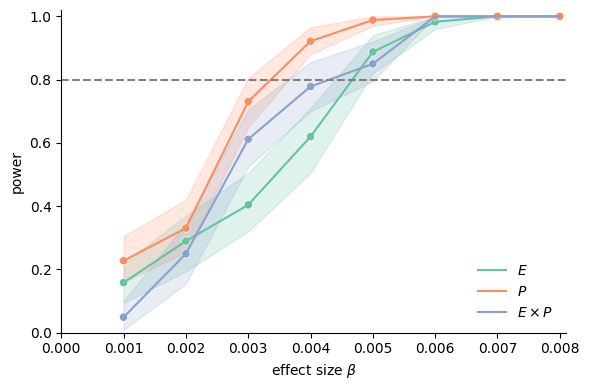

In [92]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(
    data=power_bootstrap,
    ax=ax,
    x="effect", 
    y="power",
    hue="variable",
    errorbar="pi",
    palette="Set2",
)

sns.scatterplot(
    data=power_bootstrap.groupby(["variable", "effect"]).mean().reset_index(),
    ax=ax,
    x="effect",
    y="power",
    hue="variable",
    hue_order=["$E$", "$P$", "$E \\times P$"],
    sizes=[50, 50, 50],
    palette="Set2",
    legend=False
)

ax.set_xlabel("effect size $\\beta$")
ax.spines[['right', 'top']].set_visible(False)
ax.legend(frameon=False)
ax.plot([0, 0.0081], [0.8, 0.8], '--', color="grey")
ax.set_xlim(0, 0.0081)
ax.set_ylim(0, 1.02)
plt.tight_layout()

fname = "power_analysis_elections_fact-speaking"
dst = "../plots"
plt.savefig(Path(dst, fname + ".pdf"))
plt.savefig(Path(dst, fname + ".svg"))

## Power analysis double-panel figure

In [100]:
# calculate power bootstrapped
results = pd.read_csv("../results/elections_belief-speaking_power_analysis.csv")
power_bootstrap_belief = pd.DataFrame()

n_bootstrap = 100
for beta_E, beta_P, beta_EP in zip(beta_Es, beta_Ps, beta_EPs):
    for n in range(n_bootstrap):
        res = results[
            (results["beta_E"] == beta_E) & \
            (results["beta_P"] == beta_P) & \
            (results["beta_EP"] == beta_EP)
        ].sample(frac=1, replace=True)
    
        power_E = np.nanmean(res["p_value_E"].values < alpha)
        power_P = np.nanmean(res["p_value_P"].values < alpha)
        power_EP = np.nanmean(res["p_value_EP"].values < alpha)
        
        power_bootstrap_belief = pd.concat([power_bootstrap_belief, pd.DataFrame({
            "variable":["$E$"],
            "effect":[beta_E],
            "power":[power_E],
        })])
        power_bootstrap_belief = pd.concat([power_bootstrap_belief, pd.DataFrame({
            "variable":["$P$"],
            "effect":[beta_P],
            "power":[power_P],
        })])
        power_bootstrap_belief = pd.concat([power_bootstrap_belief, pd.DataFrame({
            "variable":["$E \\times P$"],
            "effect":[beta_EP],
            "power":[power_EP]
        })])

In [94]:
# calculate power bootstrapped
results = pd.read_csv("../results/elections_fact-speaking_power_analysis.csv")
power_bootstrap_fact = pd.DataFrame()

n_bootstrap = 100
for beta_E, beta_P, beta_EP in zip(beta_Es, beta_Ps, beta_EPs):
    for n in range(n_bootstrap):
        res = results[
            (results["beta_E"] == beta_E) & \
            (results["beta_P"] == beta_P) & \
            (results["beta_EP"] == beta_EP)
        ].sample(frac=1, replace=True)
    
        power_E = np.nanmean(res["p_value_E"].values < alpha)
        power_P = np.nanmean(res["p_value_P"].values < alpha)
        power_EP = np.nanmean(res["p_value_EP"].values < alpha)
        
        power_bootstrap_fact = pd.concat([power_bootstrap_fact, pd.DataFrame({
            "variable":["$E$"],
            "effect":[beta_E],
            "power":[power_E],
        })])
        power_bootstrap_fact = pd.concat([power_bootstrap_fact, pd.DataFrame({
            "variable":["$P$"],
            "effect":[beta_P],
            "power":[power_P],
        })])
        power_bootstrap_fact = pd.concat([power_bootstrap_fact, pd.DataFrame({
            "variable":["$E \\times P$"],
            "effect":[beta_EP],
            "power":[power_EP]
        })])

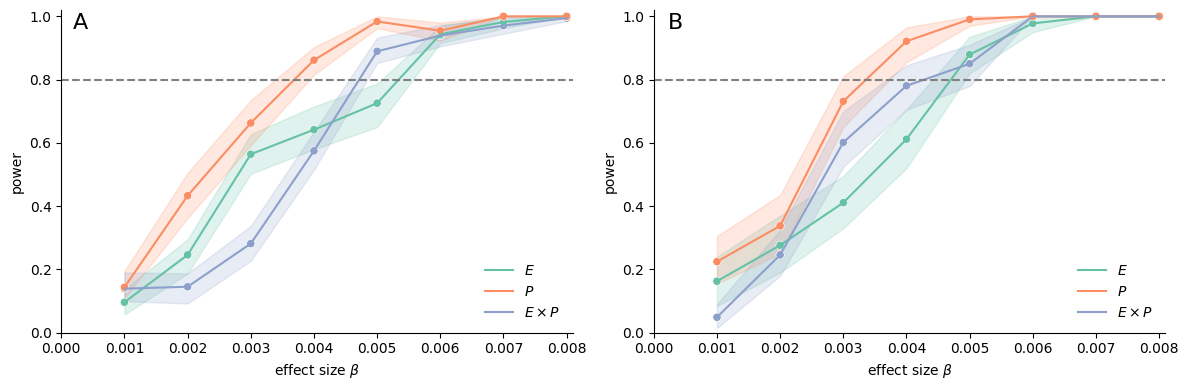

In [114]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(
    data=power_bootstrap_belief,
    ax=axes[0],
    x="effect", 
    y="power",
    hue="variable",
    errorbar="pi",
    palette="Set2",
)

sns.scatterplot(
    data=power_bootstrap_belief.groupby(["variable", "effect"]).mean().reset_index(),
    ax=axes[0],
    x="effect",
    y="power",
    hue="variable",
    hue_order=["$E$", "$P$", "$E \\times P$"],
    sizes=[50, 50, 50],
    palette="Set2",
    legend=False
)

sns.lineplot(
    data=power_bootstrap_fact,
    ax=axes[1],
    x="effect", 
    y="power",
    hue="variable",
    errorbar="pi",
    palette="Set2",
)

sns.scatterplot(
    data=power_bootstrap_fact.groupby(["variable", "effect"]).mean().reset_index(),
    ax=axes[1],
    x="effect",
    y="power",
    hue="variable",
    hue_order=["$E$", "$P$", "$E \\times P$"],
    sizes=[50, 50, 50],
    palette="Set2",
    legend=False
)

for ax in axes:
    ax.set_xlabel("effect size $\\beta$")
    ax.spines[['right', 'top']].set_visible(False)
    ax.legend(frameon=False)
    ax.plot([0, 0.0081], [0.8, 0.8], '--', color="grey")
    ax.set_xlim(0, 0.0081)
    ax.set_ylim(0, 1.02)

fig.text(0.065, 0.915, "A", fontsize=16)
fig.text(0.561, 0.915, "B", fontsize=16)
plt.tight_layout()

fname = "power_analysis_elections"
dst = "../plots"
plt.savefig(Path(dst, fname + ".pdf"))
plt.savefig(Path(dst, fname + ".svg"))

## Main analysis

TODO